In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
!pip install yfinance --upgrade --no-cache-dir
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
from sklearn.utils import shuffle
from collections import deque
import random
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

Dataset

In [ ]:
pl11 = pd.read_csv('/content/PL11_data_all_En.csv')
df = pd.DataFrame({'Capacity':None,'PerEn':None,'Cycles':np.arange(1,703)})
for i in range(132):
  df['Capacity'][pl11.iloc[i][0]] = pl11['Capacity'][i]
  df['PerEn'][pl11.iloc[i][0]] = pl11['PerEn3'][i]
df['Capacity'][701] = pl11['Capacity'][132]
df['PerEn'][701] = pl11['PerEn3'][132]

for i in range(132):
  if (df['Capacity'][i]!=None):
      df['Capacity'][0] = df['Capacity'][i]
      df['PerEn'][0] = df['PerEn'][i]
      break

for i in range(702):
  if (df['Capacity'][i]==None):
    j = i+1
    while j<=702:
      if (df['Capacity'][j]!=None):
        break
      j+=1
    df['Capacity'][i] = np.mean([df['Capacity'][i-1],df['Capacity'][j]])
    df['PerEn'][i] = np.mean([df['PerEn'][i-1],df['PerEn'][j]])

newdf = pd.DataFrame({'StandardCapacity':np.arange(1,134)})
df = pd.concat([df,newdf],axis=1)
for i in range(len(df['Capacity'])):

  if (i<=95):
    df['StandardCapacity'][i] = 1
  else:
    df['StandardCapacity'][i] = 0

df= shuffle(df)
#df = df.set_index('PerEn3')
train = df.iloc[:120]
test = df.iloc[120:]

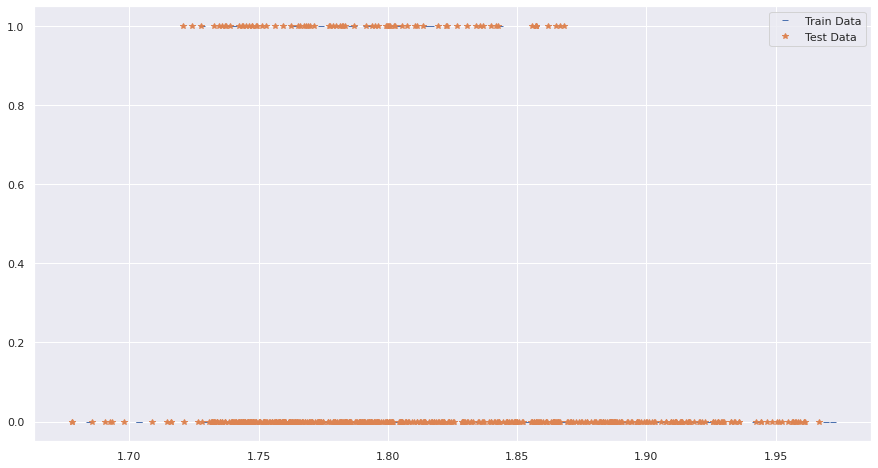

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(train.PerEn, train.StandardCapacity, '_', label = 'Train Data')
plt.plot(test.PerEn, test.StandardCapacity, '*', label = 'Test Data')
plt.legend()

Model

In [ ]:
class Agent:
    def __init__(self, state_size, window_size, train_trend, test_trend, X, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.train_trend = train_trend
        self.test_trend = test_trend
        self.skip = skip
        self.action_size = 2
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []
        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())
    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0])

    def get_state(self, t, X):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = X[d : t + 1] if d >= 0 else -d * [X[0]] + X[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i])
        return np.array([res])

    def test(self):
        #initial_capacity = 1.4393 #df['Capacity'][0]
        states_nocharge = []
        states_charge = []
        inventory = []
        state = self.get_state(0, self.test_trend)

        for t in range(0, len(self.test_trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1, self.test_trend)
            if action == 1 and t < (len(self.test_trend) - self.half_window):
                inventory.append(self.test_trend[t])
                states_charge.append(t)
                print('charge')
            elif action == 0 and len(inventory):
                states_nocharge.append(t)
                print('discharge')
            state = next_state
        #charge = (action/initial_capacity)

        return states_charge, states_nocharge  #, charge

    def train(self, epochs, checkpoint):
        epoch = []
        reward = []
        for i in range(epochs):
            total_profit = 0
            inventory = []
            state = self.get_state(0, self.train_trend)
            for t in range(0, len(self.train_trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1, self.train_trend)
                if action == 1 and t < (len(self.train_trend) - self.half_window):
                    inventory.append(self.train_trend[t])
                elif action == 0 and len(inventory) > 0:
                    total_profit += self.train_trend[t]

                self.memory.append((state, action, 
                                    next_state))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                #cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('Epoch: %d, total rewards: %f.3'%(i + 1, total_profit))
                epoch.append(i+1)
                reward.append(total_profit)

        return reward, inventory, epoch

Train

In [ ]:
train_StandardCapacity = train.StandardCapacity.values.tolist()
test_StandardCapacity = test.StandardCapacity.values.tolist()
X = train.PerEn.values.tolist()
window_size = 5
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              train_trend = train_StandardCapacity, 
              test_trend = test_StandardCapacity,
              X = X,
              skip = skip, 
              batch_size = batch_size)
reward, inventory, epoch = agent.train(epochs = 200, checkpoint = 10)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1771: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.


Epoch: 10, total rewards: 15.000000.3
Epoch: 20, total rewards: 10.000000.3
Epoch: 30, total rewards: 8.000000.3
Epoch: 40, total rewards: 13.000000.3
Epoch: 50, total rewards: 9.000000.3
Epoch: 60, total rewards: 8.000000.3
Epoch: 70, total rewards: 10.000000.3
Epoch: 80, total rewards: 10.000000.3
Epoch: 90, total rewards: 11.000000.3
Epoch: 100, total rewards: 9.000000.3
Epoch: 110, total rewards: 15.000000.3
Epoch: 120, total rewards: 12.000000.3
Epoch: 130, total rewards: 10.000000.3
Epoch: 140, total rewards: 10.000000.3
Epoch: 150, total rewards: 12.000000.3
Epoch: 160, total rewards: 12.000000.3
Epoch: 170, total rewards: 10.000000.3
Epoch: 180, total rewards: 11.000000.3
Epoch: 190, total rewards: 11.000000.3
Epoch: 200, total rewards: 10.000000.3


Evaluation

charge
discharge
discharge
discharge
discharge
discharge
discharge
charge
discharge
discharge
discharge
discharge
discharge
charge
discharge
discharge
charge
discharge
discharge
discharge
charge
charge
charge
discharge
discharge
charge
charge
discharge
discharge
discharge
discharge
discharge
charge
discharge
discharge
discharge
charge
charge
charge
discharge
charge
discharge
charge
discharge
discharge
charge
discharge
discharge
charge
discharge
discharge
charge
discharge
charge
charge
charge
discharge
charge
charge
charge
discharge
discharge
discharge
discharge
discharge
discharge
discharge
discharge
charge
discharge
discharge
discharge
discharge
charge
charge
discharge
charge
discharge
discharge
discharge
discharge
discharge
charge
charge
discharge
discharge
discharge
charge
discharge
discharge
discharge
discharge
discharge
charge
discharge
charge
discharge
charge
discharge
charge
discharge
discharge
discharge
discharge
discharge
discharge
discharge
charge
charge
charge
discharge
char

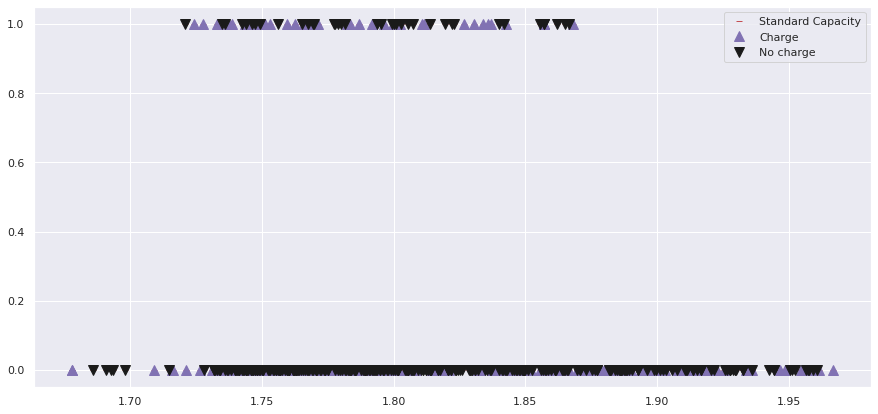

In [ ]:
states_charge, states_nocharge = agent.test()
fig = plt.figure(figsize = (15,7))
plt.plot(test['PerEn'],test_StandardCapacity,'_', color='r', lw=2., label = 'Standard Capacity')
plt.plot(test['PerEn'],test_StandardCapacity, '^', markersize=10, color='m', label = 'Charge', markevery = states_charge)
plt.plot(test['PerEn'],test_StandardCapacity, 'v', markersize=10, color='k', label = 'No charge', markevery = states_nocharge)
plt.legend()
plt.show()